<a href="https://colab.research.google.com/github/kyhofer/type-1-simulation/blob/master/type_1_model_kalman_filter_17march2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Type 1 Diabetes Blood Glucose Model

Import required fucntions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

Kalman filter setup

In [ ]:
class DiscreteKalmanFilter:
    def __init__(self, A, B, H, Q, R, initial_state_mean, initial_state_covariance):
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.state_mean = initial_state_mean
        self.state_covariance = initial_state_covariance

    def predict(self, control_input):
        # Predict the next state
        self.state_mean = np.dot(self.A, self.state_mean) + np.dot(self.B, control_input)
        self.state_covariance = np.dot(np.dot(self.A, self.state_covariance), self.A.T) + self.Q

    def update(self, measurement):
        # Measurement update
        innovation = measurement - np.dot(self.H, self.state_mean)
        innovation_covariance = np.dot(np.dot(self.H, self.state_covariance), self.H.T) + self.R
        kalman_gain = np.dot(np.dot(self.state_covariance, self.H.T), np.linalg.inv(innovation_covariance))

        # Update state estimate
        self.state_mean += np.dot(kalman_gain, innovation)
        self.state_covariance = np.dot(np.eye(len(self.state_mean)) - np.dot(kalman_gain, self.H), self.state_covariance)


Define ODE for change in glucose model
(G2=) ̇  k1*( U2*  β-U1*  α)    

In [ ]:
# Define the simplified diabetes model - state space
def diabetes_model(x, t, k1, alpha, beta):
    # Unpack state variables
    G, G_dot = x

    # Compute the rate of change of blood glucose concentration
    dGdt = G_dot
    dGdotdt = k1 * (C * beta - I * alpha)

    return [dGdt, dGdotdt]

Defining Constants for ODE model

In [ ]:
# Simulation parameters
k1 = .1  # Rate constant
alpha = 7.52 # Insulin effectiveness factor
beta = .66  # Carbohydrate effectiveness factor



Importing real world data from input excel (required to have appropriate labels and columns)

In [ ]:
# Read real data from Excel
excel_file = "BG_data.xlsx"
data_df = pd.read_excel(excel_file)
real_bg_data = data_df["BloodGlucose"].tolist()

insulin_data = data_df["Insulin"].values
carbohydrate_data = data_df["Carbohydrates"].values
# Time vector
# Adjust the length of t
t = np.linspace(0, 393,394) # len(G_out))

Setting initial gluclose value (not dynamic input but can change later)

In [ ]:
# Initial conditions
G_initial = 159  # Initial blood glucose level 159
G_dot_initial = 2  # Initial rate of change of blood glucose level


Initialize Kalman filter

In [ ]:
# Initialize Kalman filter: 1 state variable A, and two control inputs I C
A = np.array([[0, 1], [0, 0]])  # State transition matrix
B = np.array([[0],[k1]]) # Control matrix
H = np.eye(2)  # Observation matrix (identity)
Q = np.eye(2) * 1e-9  # Process noise/quality covariance
R = np.eye(2) * 1e9  # Measurement noise/reliability covariance
initial_state_mean = np.array([G_initial, G_dot_initial])  # Initial state mean
initial_state_covariance = np.eye(2) * 1  # Initial state covariance
kalman_filter = DiscreteKalmanFilter(A, B, H, Q, R, initial_state_mean, initial_state_covariance)


setting G_out (dGdt value) to [  ] and Initializing G_out to be initial glucose. Calling ODE for i in length of t.
This will call ODE for every value of i in time series for real data

In [ ]:
# Integrate the ODE using odeint
G_out = np.zeros_like(t)
G_out_dot = np.zeros_like(t)
G_out[0] = G_initial  # Set initial blood glucose level
G_out_dot[0] = G_dot_initial  # Set initial rate of change of blood glucose level
for i in range(1, len(t)):
    # Get insulin and carbohydrate values from the Excel data
    I = insulin_data[i]
    C = carbohydrate_data[i]
    # Predict the next state using the Kalman filter with control inputs
    #kalman_filter.predict(np.array([[I], [C]]))
    kalman_filter.predict(np.array([[I], [C]]).T)

    # Update the state estimate using the blood glucose measurement
    kalman_filter.update(np.array([G_out[i-1], G_out_dot[i-1]]))

    # Integrate the ODE over the interval [t[i-1], t[i]]
    state = odeint(diabetes_model, [G_out[i-1], G_out_dot[i-1]], [t[i-1], t[i]], args=(k1, alpha, beta))
    G_out[i], G_out_dot[i] = state[-1]


Plotting model data against real world data

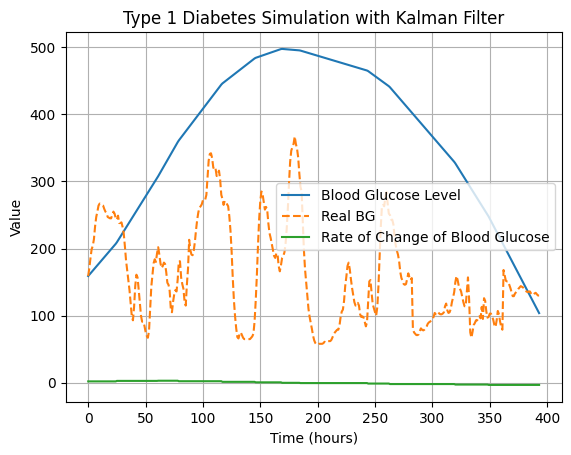

In [ ]:
# Plot the results
plt.plot(t, G_out, label='Blood Glucose Level')
plt.plot(t,real_bg_data, label='Real BG', linestyle='--')
plt.plot(t, G_out_dot, label='Rate of Change of Blood Glucose')
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.title('Type 1 Diabetes Simulation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()